<a href="https://colab.research.google.com/github/imashoodnasir/Skin-Cancer-Segmentation/blob/main/SkinCancerSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.color import rgb2grey
from sklearn.feature_extraction import image
from sklearn.cluster import KMeans

from skimage.filters import rank, threshold_otsu
from skimage.morphology import closing, square, disk
from skimage import exposure as hist, data, img_as_float
from skimage.segmentation import chan_vese
from skimage.feature import canny
from skimage.color import rgb2gray
from scipy import ndimage as ndi 


In [2]:
# Configure kaggle
os.chdir('/root/')
!mkdir -p .kaggle
os.chdir('/root/.kaggle')
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Y-o0TVcjehM8SZB3Nt8U3xkyeQu-Nse-' -O kaggle.json > /dev/null 2>&1
!ls /root/.kaggle

# Set permissions 
!chmod 600 /root/.kaggle/kaggle.json

# Create data folder
os.chdir('/content/')

kaggle.json


In [3]:
# Download data
!pip install -q kaggle
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign

 99% 322M/325M [00:11<00:00, 35.6MB/s]
100% 325M/325M [00:11<00:00, 28.9MB/s]


In [ ]:
!unzip '/content/skin-cancer-malignant-vs-benign.zip' -d '/content/dataset/'

In [5]:
mal_images = glob('/content/dataset/data/train/malignant/*')
ben_images = glob('/content/dataset/data/train/benign/*')

In [6]:
len(mal_images)

1197

In [7]:
def binary(image):
    return image > threshold_otsu(image)

def equalize(image):
    return hist.equalize_hist(image)

#https://homepages.inf.ed.ac.uk/rbf/HIPR2/median.htm
def mean_filter(image, raio_disk):
    return rank.mean_percentile(image, selem = disk(raio_disk))

def preenche_bords(image):
    return ndi.binary_fill_holes(image)

#https://www.unioviedo.es/compnum/labs/PYTHON/intro_image.html

def load_images(paths):
    tmp = []
    for path in paths:
        tmp.append(imread(path))
    return tmp
    
def plot_any(arr, title = ''):
    plt.figure(figsize = (15, 25))
    for i in range(len(arr)):
        plt.subplot(1,len(arr),i + 1)
        plt.title(title)
        plt.imshow(arr[i]);

        
def plot_camadas(img):
    plt.figure(figsize = (15, 25))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(img[:,:,i], cmap = 'gray');
        
def d2Kmeans(img, k):
    return KMeans(random_state=1, 
                  n_clusters = k, 
                  init='k-means++'
    ).fit(img.reshape((-1,1))).labels_.reshape(img.shape)

def merge_segmented_mask_ROI(uri_img, img_kluster):
    new_img = uri_img.copy()
    for ch in range(3):
        new_img[:,:, ch] *= img_kluster
    return new_img


def elbow(img, k):
    hist = []
    for kclusters in  range(1, k):
        Km = KMeans(random_state=1, n_clusters = kclusters, init='k-means++').fit(img.reshape((-1,1)))  
        hist.append(Km.inertia_)
        
    plt.figure(figsize = (15, 8))
    plt.grid()
    plt.plot(range(1, k), hist, 'o-')
    plt.ylabel('Soma das distâncias quadradas')
    plt.xlabel('k clusters')
    plt.title('Elbow')
    plt.show();

In [8]:
mal = load_images(mal_images)
ben = load_images(ben_images)

In [ ]:
plot_any(mal, 'Maligna')
plot_any(ben, 'Benigma')

In [9]:
img_selected = mal[1]

In [10]:
k_klusters = 2

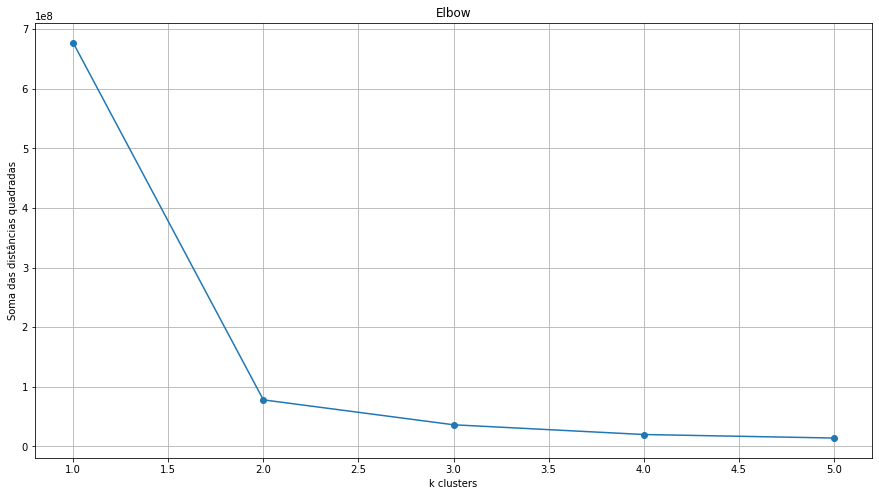

In [11]:
elbow(img_selected, 6)

In [12]:
result_gray = d2Kmeans(rgb2grey(img_selected), k_klusters)
result_img = d2Kmeans(img_selected, k_klusters)

<ipython-input-12-e6dabbc0acd3>:1: FutureWarning: rgb2grey is deprecated. It will be removed in version 0.19.Please use rgb2gray instead.
  result_gray = d2Kmeans(rgb2grey(img_selected), k_klusters)


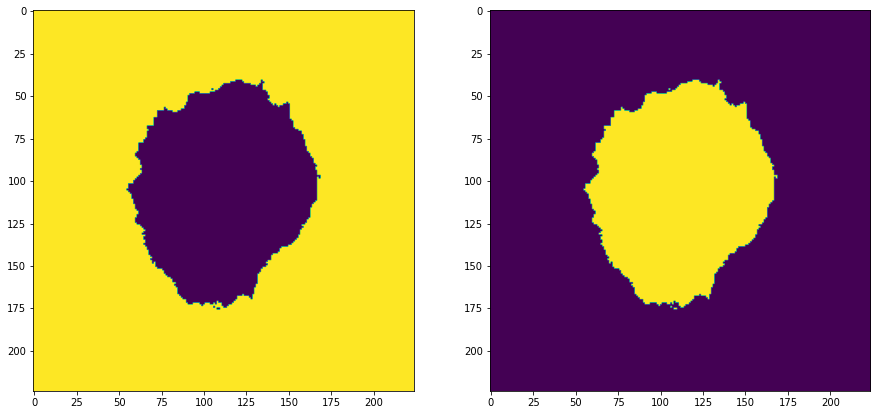

In [13]:
klusters_gray = [result_gray == i for i in range(k_klusters)]
plot_any(klusters_gray)

In [14]:
def select_cluster_index(clusters):
    minx = clusters[0].mean()
    index = 0
    for i in clusters:
        if i.mean() < minx:
            minx = i.mean()
            index += 1
    return index

In [15]:
index_kluster = select_cluster_index(klusters_gray)
print(index_kluster)
selecionado = klusters_gray[index_kluster]


1


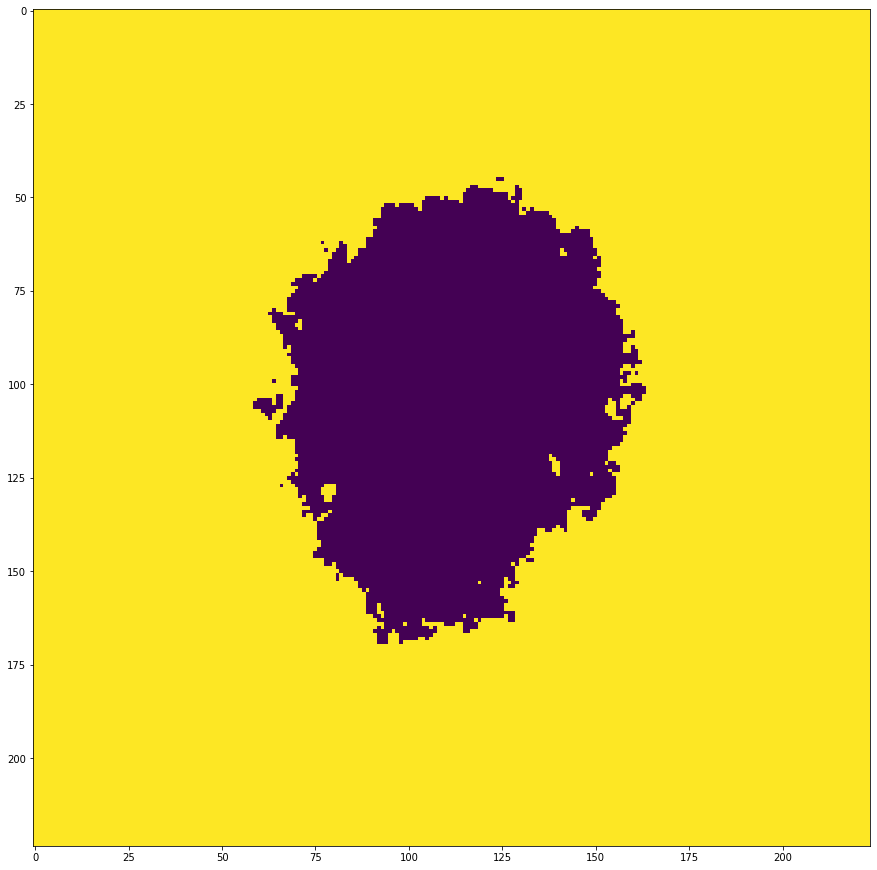

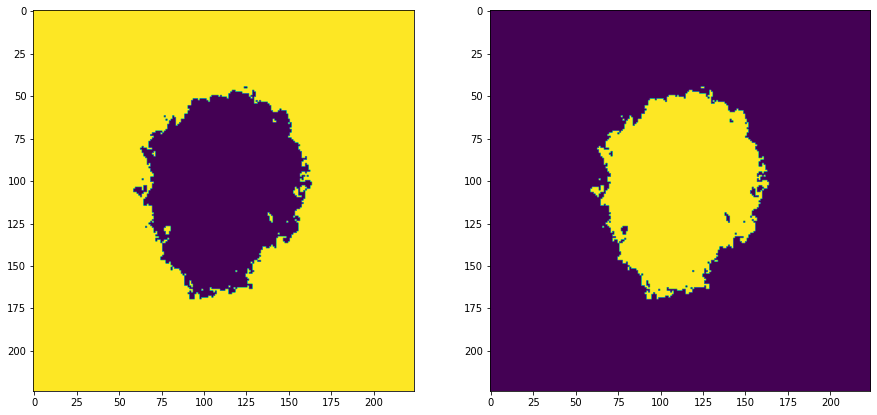

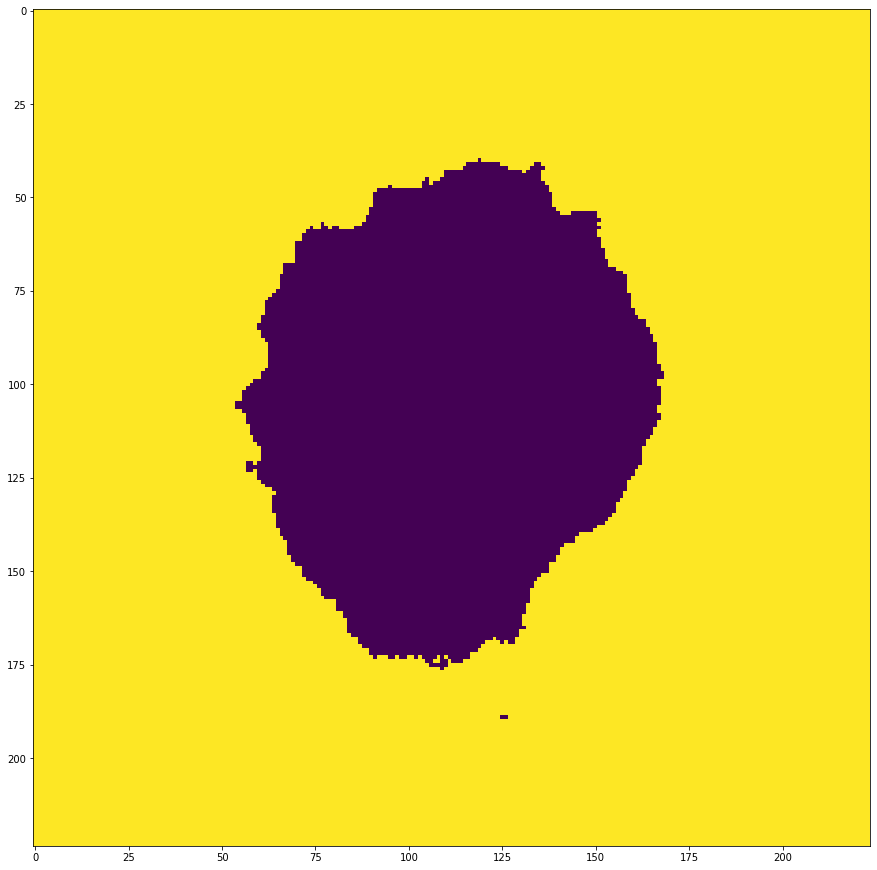

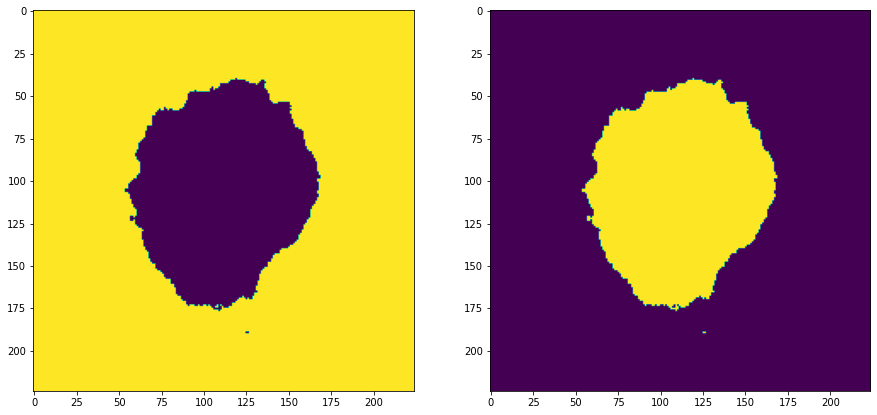

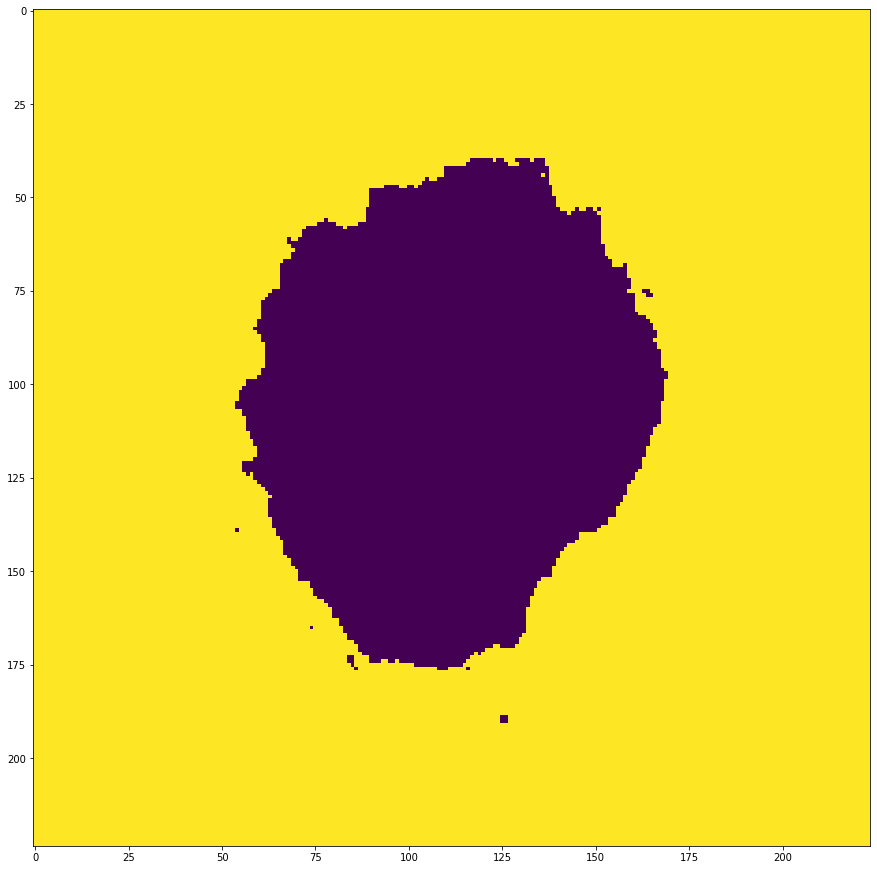

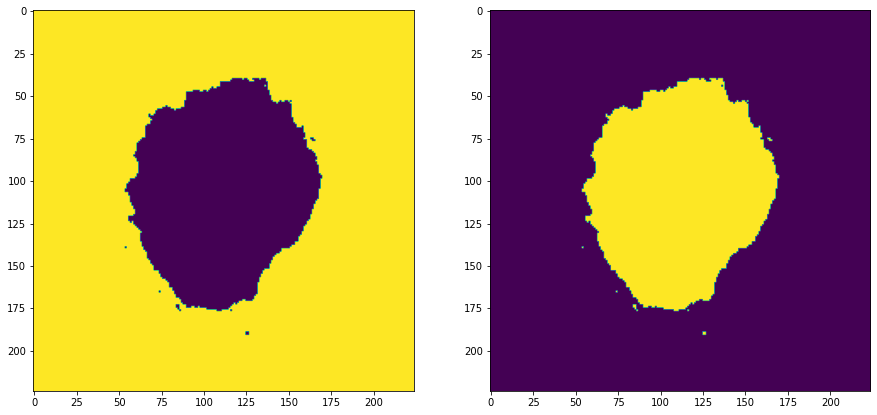

In [17]:
for ch in range(3):
  img_k = []
  for K in range(k_klusters):
    img_k.append(result_img[:, :, ch] == K)
    plot_any(img_k)

In [18]:
clusters = [(result_img[:,:,1] == K) for K in range(k_klusters)]

In [19]:
new_img = merge_segmented_mask_ROI(img_selected, selecionado)

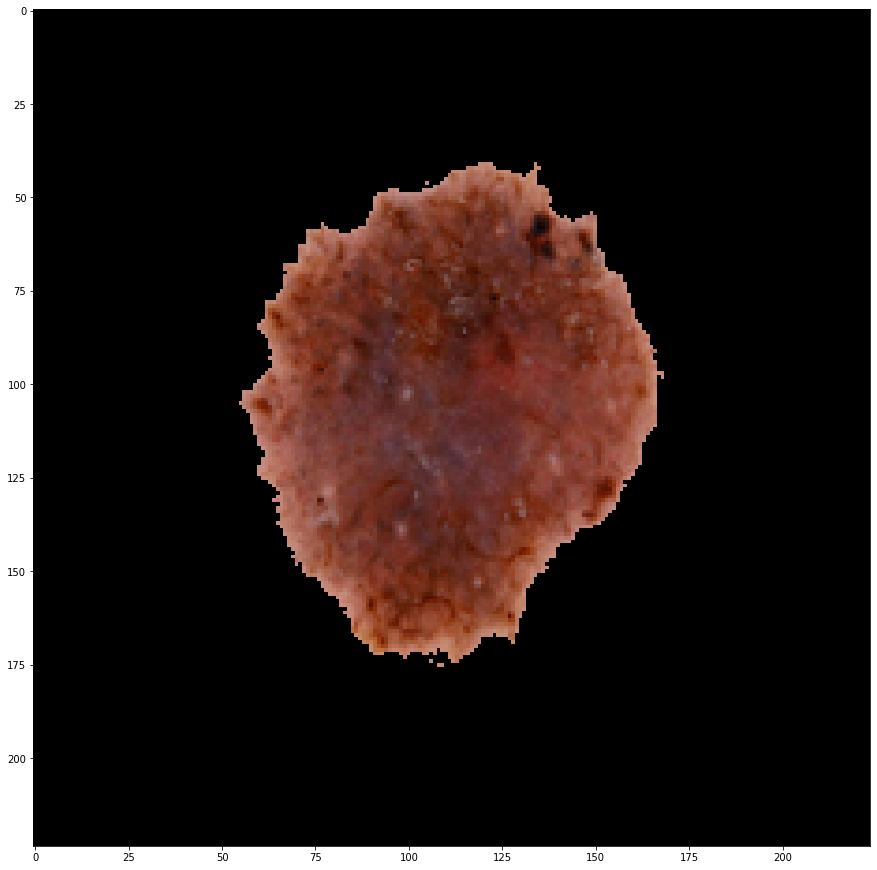

In [20]:
plot_any([new_img])

In [ ]:

image_mean_filter = mean_filter(result_gray, 20)
test_binary = binary(image_mean_filter)

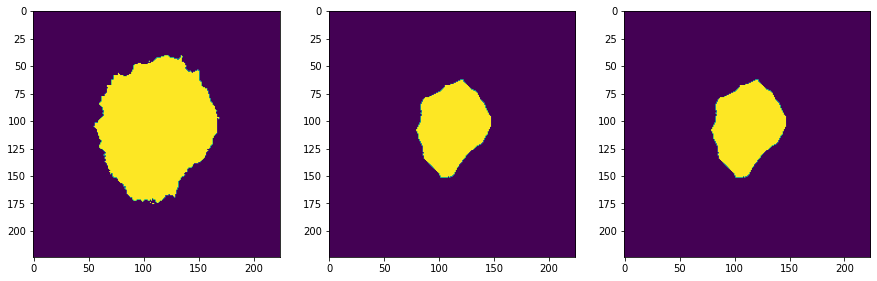

In [43]:
plot_any([selecionado, image_mean_filter, test_binary])

In [44]:
final_result = merge_segmented_mask_ROI(img_selected ,test_binary)

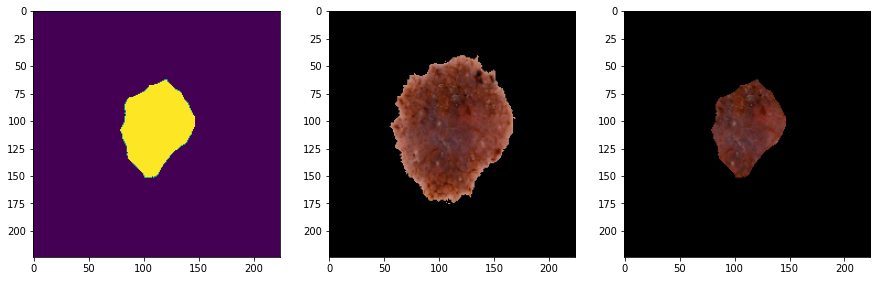

In [45]:
plot_any([test_binary, new_img, final_result])

<ipython-input-52-aea6b322290b>:27: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  mean_result = mean_filter(img_copy, 15)


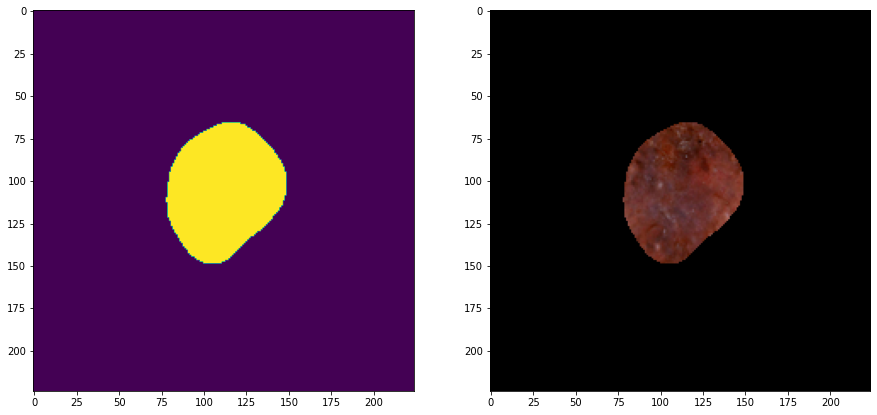

In [52]:
max_mean = 0
img_gray = rgb2gray(final_result)
img_bin  = img_gray
x, y = img_bin.shape
limits_before = []
for i in range(x):
    for j in range(y):
        if  img_bin[i, j]:
            limits_before.append(j)
            
stop_before = ( sum(limits_before) // len(limits_before) ) // 2
img_copy = img_bin.copy()
for i in range(x):
    for j in range(stop_before):
        img_copy[i, j] = 0
        limits_after = []
for i in range(x):
     for j in range(y - 1, 0, -1):
        if  img_copy[i, j]:
            limits_after.append(j)
            
stop_after = sum(limits_after) // len(limits_after) + min(limits_after)
for i in range(x):
    for j in range(stop_after, y):
        img_copy[i, j] = 0

mean_result = mean_filter(img_copy, 15)
mean_result = binary(mean_result)
final_result = merge_segmented_mask_ROI(img_selected , mean_result)


plot_any([mean_result, final_result])

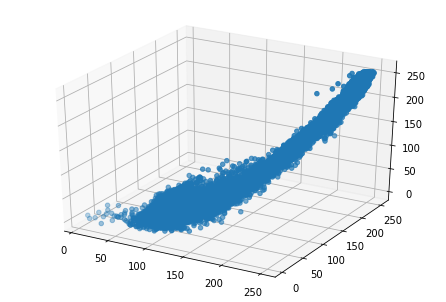

In [54]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
import numpy as np
img = cv2.imread(mal_images[1]) 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
r, g, b = cv2.split(img)
r = r.flatten()
g = g.flatten()
b = b.flatten()
#plotting 
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(r, g, b)
plt.show()

In [59]:
original_image = cv2.imread(mal_images[1])
img=cv2.cvtColor(original_image,cv2.COLOR_BGR2RGB)
vectorized = img.reshape((-1,3))
vectorized = np.float32(vectorized)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
attempts=10
ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((img.shape))

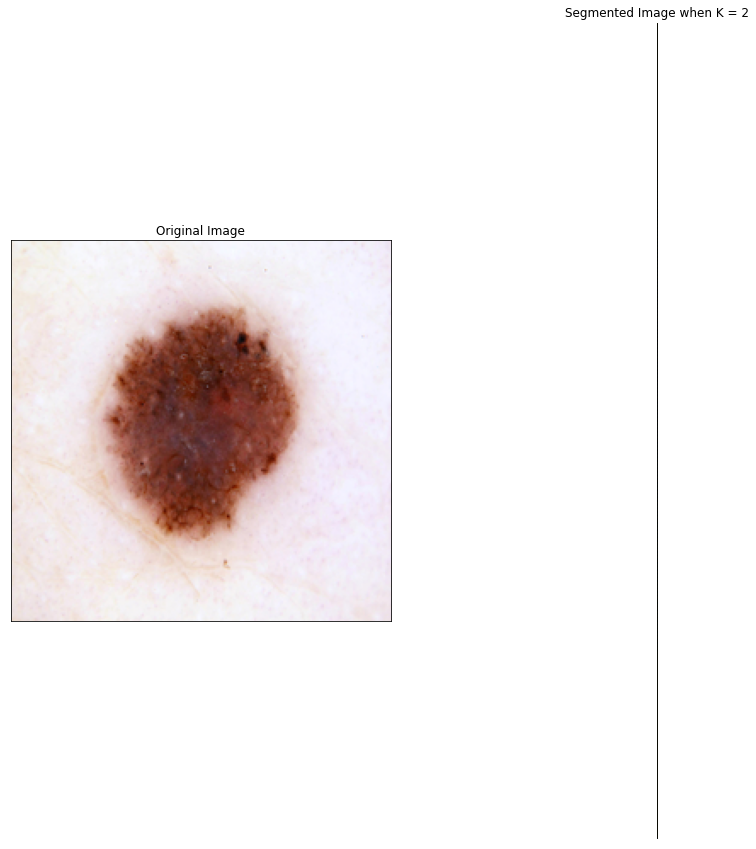

In [60]:
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(res)
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

In [61]:
import sys
import sklearn
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

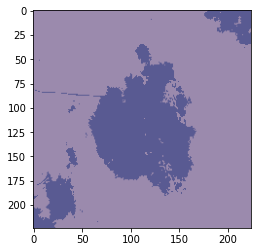

In [62]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

image = cv2.imread(mal_images[2])
(h1, w1) = image.shape[:2]

image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

image = image.reshape((image.shape[0] * image.shape[1], 3))

clt = KMeans(n_clusters = 2)

labels = clt.fit_predict(image)
quant = clt.cluster_centers_.astype("uint8")[labels]

#reshape the feature vectors to images
quant = quant.reshape((h1, w1, 3))
image = image.reshape((h1, w1, 3))

# convert from L*a*b* to RGB
quant = cv2.cvtColor(quant, cv2.COLOR_LAB2BGR)
image = cv2.cvtColor(image, cv2.COLOR_LAB2BGR)



plt.imshow(quant)

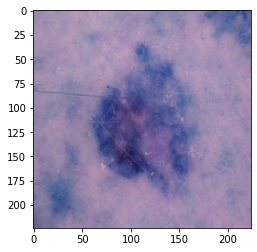

In [63]:
plt.imshow(image)

In [65]:
mal_images = glob('/content/dataset/data/train/malignant/*')
ben_images = glob('/content/dataset/data/train/benign/*')

In [66]:
len(mal_images)

1197

In [67]:
#Reading Image
import pandas as pd
train_data =[]
for img in  mal_images :
    train_data.append((img,0)) 
    
for img in ben_images : 
    train_data.append((img,1)) 

    
train_data = pd.DataFrame(train_data, columns = ['image','label'] , index = None)
train_data['image'][0] 
train_data

,image,label
0,/content/dataset/data/train/malignant/280.jpg,0
1,/content/dataset/data/train/malignant/955.jpg,0
2,/content/dataset/data/train/malignant/829.jpg,0
3,/content/dataset/data/train/malignant/1414.jpg,0
4,/content/dataset/data/train/malignant/754.jpg,0
...,...,...
2632,/content/dataset/data/train/benign/133.jpg,1
2633,/content/dataset/data/train/benign/21.jpg,1
2634,/content/dataset/data/train/benign/966.jpg,1
2635,/content/dataset/data/train/benign/738.jpg,1


In [72]:
mal_images = glob('/content/dataset/data/train/malignant/*')

In [73]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir('/content/dataset/data/train/malignant'))

# Any results you write to the current directory are saved as output.

#import os
import cv2
W=256
path = r"/content/dataset/data/train/malignant"
for filename in os.listdir(path):
    if filename.endswith('.jpg'):
        print(filename)
        oriimg = cv2.imread(path+'/'+filename)
        height, width, depth = oriimg.shape
        imgScale = W/width
        newX,newY = oriimg.shape[1]*imgScale, oriimg.shape[0]*imgScale
        newimg = cv2.resize(oriimg,(int(newX),int(newY)))
        newimg = cv2.cvtColor(oriimg,cv2.COLOR_BGR2GRAY)
        cv2.imwrite(str(path+'/'+filename+"-resized"),newimg)        
        print('Image saved')

['777.jpg-resized', '280.jpg', '955.jpg', '829.jpg', '1446.jpg-resized', '1414.jpg', '754.jpg', '986.jpg-resized', '132.jpg', '975.jpg-resized', '227.jpg', '147.jpg-resized', '151.jpg-resized', '1232.jpg-resized', '1393.jpg-resized', '7.jpg', '55.jpg', '723.jpg', '1272.jpg', '920.jpg', '913.jpg-resized', '608.jpg-resized', '119.jpg-resized', '456.jpg-resized', '571.jpg-resized', '1357.jpg', '772.jpg', '1116.jpg', '1081.jpg-resized', '1264.jpg', '1063.jpg', '553.jpg', '1314.jpg-resized', '1392.jpg', '1133.jpg-resized', '233.jpg-resized', '1264.jpg-resized', '681.jpg-resized', '274.jpg', '733.jpg-resized', '1052.jpg', '1469.jpg-resized', '337.jpg-resized', '212.jpg', '959.jpg-resized', '650.jpg', '37.jpg', '1367.jpg-resized', '429.jpg-resized', '427.jpg-resized', '851.jpg', '505.jpg', '843.jpg-resized', '136.jpg-resized', '28.jpg-resized', '111.jpg-resized', '604.jpg-resized', '942.jpg', '869.jpg', '47.jpg', '941.jpg-resized', '873.jpg-resized', '249.jpg', '1030.jpg', '267.jpg', '1493.jp